# Forward encoding model based on Pim Mostert Decoding toolbox

In [1]:
!pwd

/Users/junjieji/Documents/GitHub/master-thesis


In [3]:
import sys
import time as tic
# %matplotlib qt
from scipy.io import loadmat
import numpy as np
import pandas as pd
import mat73

import inspect #path_fun = inspect.getfile(StratifiedKFold)
import matplotlib.pyplot as plt
import mne
import os
import random

from statsmodels.tsa.stattools import coint


In [4]:
path_utils = '/decoding_toolbox_py/helper_funcs' 
sys.path.append(path_utils)

# Variables

In [5]:
''' VARIABLES '''

dataset = 'eeg'

amount_of_subjects = 1# Change the range so the process is faster
if amount_of_subjects > 26: amount_of_subjects = 26
subjs_list = ['s{:02d}'.format(i) for i in range(1, amount_of_subjects+1) if i != 6 ] 
nSubj = len(subjs_list)

numC = 8

angles = [i * 180./numC for i in range(numC)]

x_labels = np.array(angles)

resample = False # speeds up the procees but showing worse results overall
if resample: resample_frequency = 20 # in Hz, original freq is 500Hz

cfg_stim = dict()
cfg_stim['kappa'] = 4
cfg_stim['NumC'] = numC
cfg_stim['Tuning'] = 'vonmises'
# cfg_stim['Tuning'] = 'halfRectCos'
cfg_stim['offset'] = 0

cfg_train = dict()
cfg_train['gamma'] = 0.1
cfg_train['demean'] = True
cfg_train['returnPattern'] = True

cfg_test = dict()
cfg_test['demean'] = 'traindata'

# Loading & preparing orientation data

In [6]:
'''EEG Dataset'''
def read_data(
        repetitions=False,
        number_of_repetition=3,
        resample=False,
        resample_frequency = 20,
        subjs_list = subjs_list,
        task = 'main'
        ):
    path = 'Cond_CJ_EEG'

    epochs = []
    all_epochs = []
    all_rawdata = []
    all_st_epochs = []
    all_st_rawdata = []
    for subject_id in subjs_list:
        preproc_path = os.path.join(path, subject_id)

        if task == 'main':
            epoch = mne.read_epochs(os.path.join(preproc_path, 'main_epo.fif'), verbose=False)
            
            if resample: 
                print('Frequency before:', epoch.info['sfreq'])
                epoch = epoch.resample(resample_frequency)
                print('Frequency after:' ,epoch.info['sfreq'])

            # epochs.append(epoch.average())
            all_epochs.append(epoch)
            all_rawdata.append({'epoch_dat': epoch.get_data(), 'metadata': epoch.metadata})
            
        if task == 'stim':
        
            st_epoch = mne.read_epochs(os.path.join(preproc_path, 'mainstim_epo.fif'), verbose=False)
            # print(st_epoch.info['sfreq'])
            if resample: 
                print('Frequency before:', st_epoch.info['sfreq'])
                st_epoch = st_epoch.resample(resample_frequency)
                print('Frequency after:' ,st_epoch.info['sfreq'])
                
            all_st_epochs.append(st_epoch)
            if repetitions:
                all_st_rawdata.append(
                    {
                    'epoch_dat': st_epoch.get_data()[st_epoch.metadata['nrep'] == number_of_repetition,:,:] ,
                    'metadata': st_epoch.metadata[st_epoch.metadata['nrep'] == number_of_repetition]
                    }
                    )
            else:
                all_st_rawdata.append({'epoch_dat': st_epoch.get_data(), 'metadata': st_epoch.metadata})
    if task == 'main':
        return all_rawdata
    else:
        return all_st_rawdata



# Procedure for multisubject

In [8]:

def train(all_st_rawdata, raw_predicts = False):
    nSubj = len(all_st_rawdata)
    preds = [None] * nSubj
    G = [None] * nSubj

    for subj in range(nSubj):
        
        Y = all_st_rawdata[subj]['epoch_dat']
        if subj == 1: print(Y.shape)
        Y = np.einsum('kji->jik', Y)        
        if subj == 1: print(Y.shape)
        
        Y = np.delete(Y, 25, axis=0)

        X = np.array(all_st_rawdata[subj]['metadata'].orient)
        X = np.digitize(X, bins = np.array(angles))-1.
        phi = X * (180./numC)
        numF, numT, numN = Y.shape

        G[subj] = X.copy() 
        
        CONDS = np.unique(G[subj])
        nConds = CONDS.size
        nfold = 5
        FoldsIdx = CreateFolds(G[subj], Y, nfold)
        
        design, sortedesign = dt.stim_features(phi, cfg_stim)
        
        Xhat = np.zeros([numC,numN, numT])
        for it in range(numT):
            cfg = dict()
            cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
            cfg['cfgD'] = {'demean' : 'traindata'}
            Xhat[:,:,it] = CV_encoder(design, Y, it, cfg, FoldsIdx)
        preds[subj] = Xhat
    if raw_predicts:
        return preds
    else:
        m_centered = np.zeros((numC,numC, numT, nSubj))
        for ival, isubj in enumerate(subjs_list):
            Xhat = preds[ival]
            Xhat_centered = 0*Xhat.copy()
            
            for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
                Xhat_centered[:, G[ival] == ic,:] = np.roll(Xhat[:,G[ival] == ic,:], -ic, axis = 0)
                m_centered[:,ic, :, ival] =  np.mean( Xhat_centered[:,  G[ival] == ic, :], axis = 1)

        Xhat_centeredmean = np.mean( m_centered, axis = 1)
        Xhat_centeredmean = np.mean( Xhat_centeredmean, axis = 2)
        
        return Xhat_centeredmean
    
def train_2(all_rawdata, raw_predicts = False):
    nSubj = len(all_rawdata)
    preds = [None] * nSubj
    G = [None] * nSubj

    for subj in range(nSubj):
        
        Y = all_rawdata[subj]['epoch_dat']
        if subj == 1: print(Y.shape)
        Y = np.einsum('kji->jik', Y)        
        if subj == 1: print(Y.shape)
        
        Y = np.delete(Y, 25, axis=0)

        
        all_rawdata[subj]['metadata']['condv'] = 'C'
        all_rawdata[subj]['metadata'].loc[all_rawdata[subj]['metadata']['cond']== 1, 'condv'] =  'D'

        X = np.array(all_rawdata[subj]['metadata'].condv)
        phi = X
        numF, numT, numN = Y.shape

        G[subj] = X.copy() 
        
        CONDS = np.unique(G[subj])
        nConds = CONDS.size
        nfold = 5
        FoldsIdx = CreateFolds(G[subj], Y, nfold)
        
        design, sortedesign = dt.stim_features(phi, cfg_stim)
        
        Xhat = np.zeros([numC,numN, numT])
        for it in range(numT):
            cfg = dict()
            cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
            cfg['cfgD'] = {'demean' : 'traindata'}
            Xhat[:,:,it] = CV_encoder(design, Y, it, cfg, FoldsIdx)
        preds[subj] = Xhat
    if raw_predicts:
        return preds
    else:
        m_centered = np.zeros((numC,numC, numT, nSubj))
        for ival, isubj in enumerate(subjs_list):
            Xhat = preds[ival]
            Xhat_centered = 0*Xhat.copy()
            
            for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
                Xhat_centered[:, G[ival] == ic,:] = np.roll(Xhat[:,G[ival] == ic,:], -ic, axis = 0)
                m_centered[:,ic, :, ival] =  np.mean( Xhat_centered[:,  G[ival] == ic, :], axis = 1)

        Xhat_centeredmean = np.mean( m_centered, axis = 1)
        Xhat_centeredmean = np.mean( Xhat_centeredmean, axis = 2)
        
        return Xhat_centeredmean
    
def train_main_ori(all_rawdata, raw_predicts = False, use_orientation = 1):
    nSubj = len(all_rawdata)
    preds = [None] * nSubj
    G = [None] * nSubj
    orientation = ['o1', 'o2', 'o3', 'o4', 'o5', 'o6']
    for subj in range(nSubj):
        
        Y = all_rawdata[subj]['epoch_dat']
        if subj == 1: print(Y.shape)
        Y = np.einsum('kji->jik', Y)        
        if subj == 1: print(Y.shape)
        
        Y = np.delete(Y, 25, axis=0)

        X = np.array(all_rawdata[subj]['metadata'][orientation[use_orientation]])
        X = X*180./np.pi
        X = np.digitize(X, bins = np.array(angles))-1.
        phi = X * (180./numC)
        numF, numT, numN = Y.shape

        G[subj] = X.copy() 
        
        CONDS = np.unique(G[subj])
        nConds = CONDS.size
        nfold = 5
        FoldsIdx = CreateFolds(G[subj], Y, nfold)
        
        design, sortedesign = dt.stim_features(phi, cfg_stim)
        
        Xhat = np.zeros([numC,numN, numT])
        for it in range(numT):
            cfg = dict()
            cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
            cfg['cfgD'] = {'demean' : 'traindata'}
            Xhat[:,:,it] = CV_encoder(design, Y, it, cfg, FoldsIdx)
        preds[subj] = Xhat
    if raw_predicts:
        return preds
    else:
        m_centered = np.zeros((numC,numC, numT, nSubj))
        for ival, isubj in enumerate(subjs_list):
            Xhat = preds[ival]
            Xhat_centered = 0*Xhat.copy()
            
            for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
                Xhat_centered[:, G[ival] == ic,:] = np.roll(Xhat[:,G[ival] == ic,:], -ic, axis = 0)
                m_centered[:,ic, :, ival] =  np.mean( Xhat_centered[:,  G[ival] == ic, :], axis = 1)

        Xhat_centeredmean = np.mean( m_centered, axis = 1)
        Xhat_centeredmean = np.mean( Xhat_centeredmean, axis = 2)
        
        return Xhat_centeredmean

In [9]:
all_rawdata = read_data(task='main')
all_st_rawdata = read_data(task='stim')
main_cols = all_rawdata[0]['metadata'].columns
main_shape = all_rawdata[0]['epoch_dat'].shape
stim_cols = all_st_rawdata[0]['metadata'].columns
stim_shape = all_st_rawdata[0]['epoch_dat'].shape
ori = ['o1', 'o2', 'o3', 'o4', 'o5', 'o6']

print(all_rawdata[0]['metadata'][ori[1]])
print(main_shape, main_cols)

883     0.715000
896     0.715000
909     0.715000
922     2.694000
935     2.694000
          ...   
4240    1.723000
4253    1.723000
4266    1.723000
4279    1.207000
4305    2.777796
Name: o2, Length: 250, dtype: float64
(250, 32, 2876) Index(['index', 'subj', 'nblock', 'ntrial', 'nrep', 'trial_type', 'cond-1',
       'cond', 'rDV', 'DV', 'resp', 'deci-2', 'deci-1', 'deci', 'corr-1',
       'r_map', 'correct', 'confi', 'RT', 'd1', 'conf_lvl', 'correct-1', 'd2',
       'd3', 'd4', 'd5', 'd6', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'confi-1',
       'conf_lvl-1'],
      dtype='object')


In [10]:
prt = all_rawdata[0]['metadata']['o6']
print(np.unique(prt))
print(np.min(prt), np.max(prt))

[3.00000000e-03 3.00000000e-02 8.62036732e-02 1.18203673e-01
 1.94000000e-01 2.28000000e-01 2.49000000e-01 2.72203673e-01
 2.89203673e-01 2.90000000e-01 3.01203673e-01 3.32000000e-01
 3.43000000e-01 3.55203673e-01 3.65000000e-01 3.73000000e-01
 3.73203673e-01 4.16203673e-01 4.68000000e-01 4.76000000e-01
 4.83000000e-01 4.83203673e-01 4.88000000e-01 5.09000000e-01
 5.28000000e-01 5.68203673e-01 5.84000000e-01 6.11203673e-01
 6.46000000e-01 6.68000000e-01 6.72000000e-01 7.05000000e-01
 7.44000000e-01 7.59000000e-01 8.28000000e-01 8.32203673e-01
 8.45000000e-01 8.49000000e-01 9.66000000e-01 1.01800000e+00
 1.02700000e+00 1.04200000e+00 1.08220367e+00 1.09900000e+00
 1.12600000e+00 1.13000000e+00 1.15500000e+00 1.16720367e+00
 1.21900000e+00 1.24300000e+00 1.28120367e+00 1.28220367e+00
 1.34000000e+00 1.36920367e+00 1.37800000e+00 1.42720367e+00
 1.43400000e+00 1.43600000e+00 1.46220367e+00 1.48820367e+00
 1.54400000e+00 1.54900000e+00 1.55000000e+00 1.57379633e+00
 1.65700000e+00 1.664000

In [ ]:
'''17 min for 1 orientation, estimate 2 hours for all 6 :)'''

amount_of_orientations = 6
Xhat_centeredmean = [None]*amount_of_orientations
for i in range(amount_of_orientations):
    print('Working on orientation: ', i+1)
    Xhat_centeredmean[i]= train_main_ori(all_rawdata, use_orientation=i)

Working on orientation:  1
(261, 32, 2876)
(32, 2876, 261)


KeyboardInterrupt: 

In [ ]:
stop and plot it

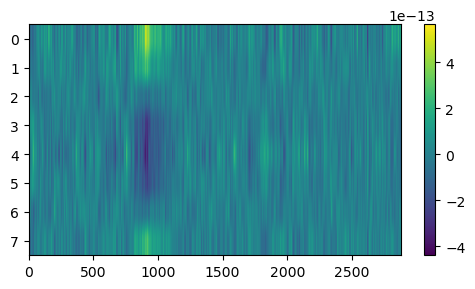

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plt.imshow(Xhat_centeredmean,aspect='auto')
plt.colorbar()

In [ ]:
'''data exploring maybe remove this cell'''
# import sklearn
# # all_st_rawdata_rep[0][0]['metadata'].columns
# ival = 0
# lab = sklearn.preprocessing.LabelEncoder()
# Y = all_rawdata[ival]['epoch_dat'] 
# all_rawdata[ival]['metadata']['condv'] = 'C'
# all_rawdata[ival]['metadata'].loc[all_rawdata[ival]['metadata']['cond']== 1, 'condv'] =  'D'
# dv  = np.array(all_rawdata[ival]['metadata'].condv)
# print(dv)
# dv = lab.fit_transform(dv)
# print(dv)

['C' 'C' 'C' 'C' 'C' 'C' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'C' 'C' 'C'
 'C' 'C' 'C' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D'
 'C' 'C' 'C' 'C' 'C' 'C' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'C' 'C' 'C'
 'D' 'D' 'D' 'C' 'C' 'C' 'D' 'D' 'D' 'C' 'C' 'C' 'D' 'D' 'D' 'D' 'D' 'D'
 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'D' 'D' 'D' 'C' 'C' 'C' 'C' 'C' 'C' 'D'
 'D' 'D' 'C' 'C' 'C' 'D' 'D' 'D' 'D' 'D' 'D' 'C' 'C' 'C' 'D' 'D' 'D' 'C'
 'C' 'C' 'C' 'C' 'D' 'D' 'D' 'D' 'D' 'C' 'C' 'C' 'D' 'D' 'D' 'D' 'D' 'D'
 'D' 'D' 'D' 'D' 'D' 'D' 'C' 'C' 'C' 'D' 'D' 'D' 'C' 'C' 'C' 'D' 'D' 'D'
 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'C' 'C' 'C' 'D' 'D' 'D' 'D'
 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'C' 'C' 'C' 'C' 'C' 'D' 'D' 'D' 'C' 'C'
 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'D' 'D' 'C' 'C' 'D' 'D' 'D' 'D' 'D' 'D' 'D'
 'D' 'D' 'C' 'C' 'C' 'C' 'C' 'C' 'D' 'D' 'D' 'D' 'D' 'C' 'C' 'D' 'D' 'D'
 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'C' 'C' 'C' 'D' 'D' 'D' 'C' 'C' 'C'
 'C' 'C' 'C' 'D' 'D' 'D' 'C' 'C' 'C' 'D' 'D' 'C' 'C

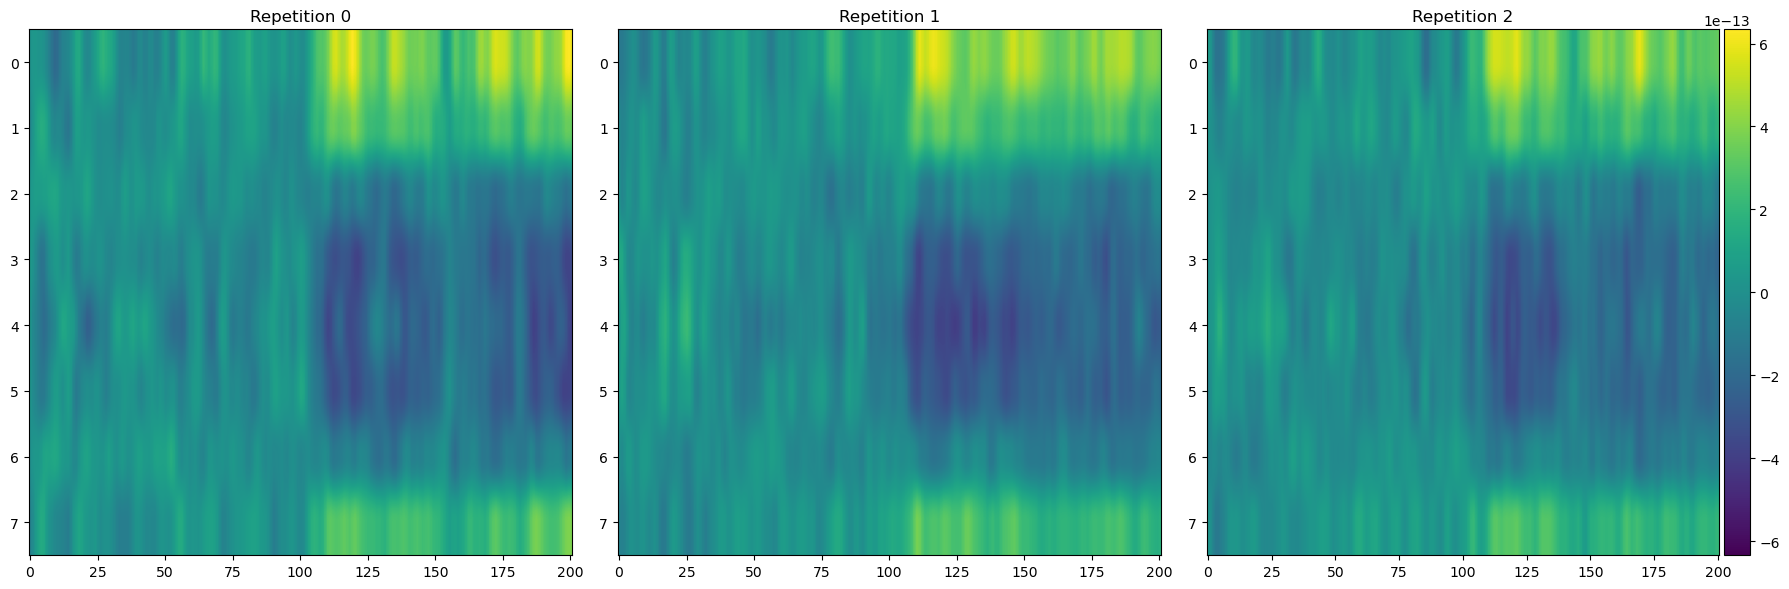

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

max_abs = np.max(np.abs(Xhat_centeredmean_rep))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

im0 = axes[0].imshow(Xhat_centeredmean_rep[0], aspect='auto', vmin=-max_abs, vmax=max_abs)
axes[0].set_title('Repetition 0')

im1 = axes[1].imshow(Xhat_centeredmean_rep[1], aspect='auto', vmin=-max_abs, vmax=max_abs)
axes[1].set_title('Repetition 1')

im2 = axes[2].imshow(Xhat_centeredmean_rep[2], aspect='auto', vmin=-max_abs, vmax=max_abs)
axes[2].set_title('Repetition 2')

divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax)

plt.tight_layout()
plt.show()



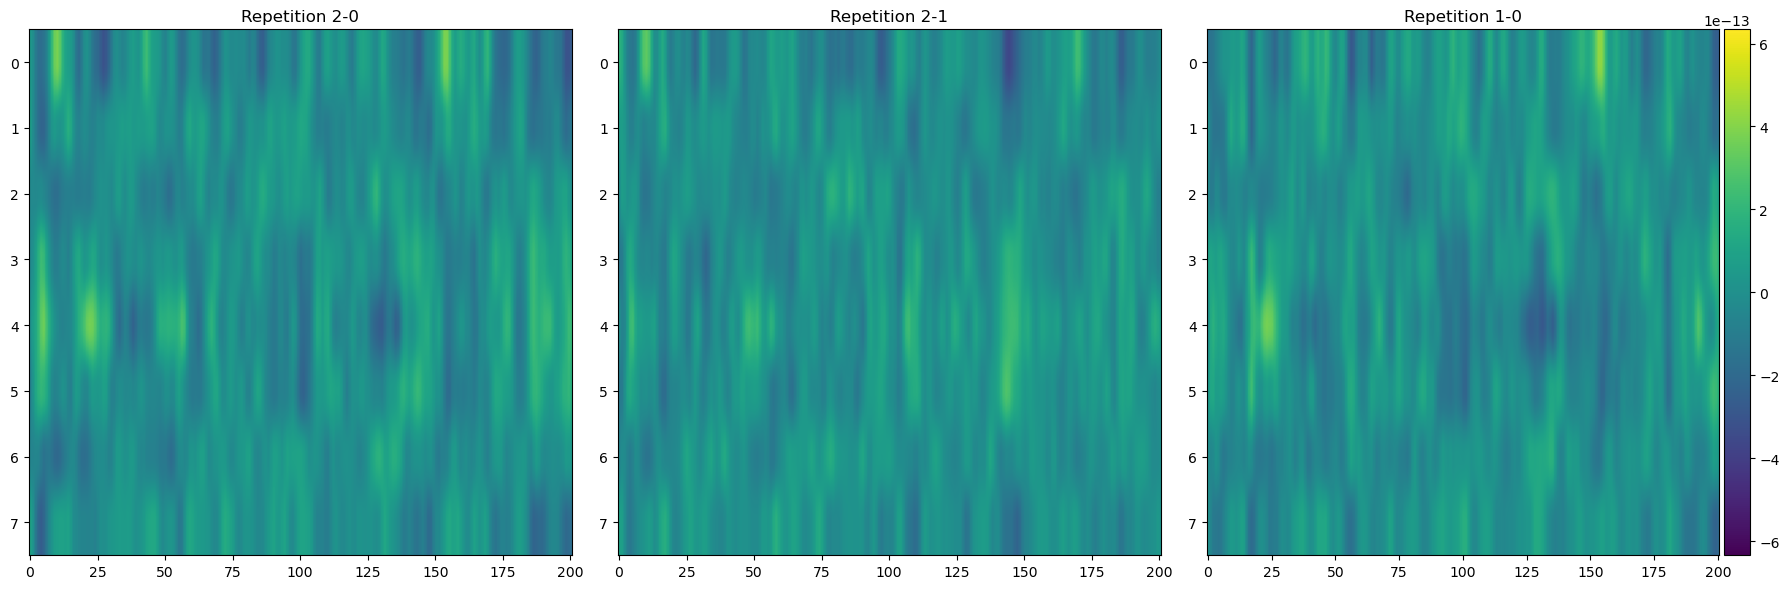

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

im0 = axes[0].imshow(Xhat_centeredmean_rep[2] - Xhat_centeredmean_rep[0], aspect='auto', vmin=-max_abs, vmax=max_abs)
axes[0].set_title('Repetition 2-0')

im1 = axes[1].imshow(Xhat_centeredmean_rep[2] - Xhat_centeredmean_rep[1], aspect='auto', vmin=-max_abs, vmax=max_abs)
axes[1].set_title('Repetition 2-1')

im2 = axes[2].imshow(Xhat_centeredmean_rep[1] - Xhat_centeredmean_rep[0], aspect='auto', vmin=-max_abs, vmax=max_abs)
axes[2].set_title('Repetition 1-0')

divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax)

plt.tight_layout()
plt.show()


In [ ]:
stophere

NameError: name 'stophere' is not defined

In [ ]:


'''

Cluster based simulation, buscarlo en mne

'''

'''

Clasificar reponse (quizas no sale)

clasificar actividad motora (si que sale)

6 min de loc
main task
6 min de loc

MAIN TASK son 6 stimulos, long ts. 

'''


https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

# crossmodal